<a href="https://colab.research.google.com/github/sriloksagar/NLP/blob/master/Text_Recognition_using_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
# uncomment while running for the first time
!pip install keras-ocr
!apt-get install poppler-utils  # dependency for pdf2image
!pip install pdf2image

Reading package lists... Done
Building dependency tree       
Reading state information... Done
poppler-utils is already the newest version (0.62.0-2ubuntu2.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [63]:
# connecting to google drive to access files
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [64]:
import os
from pdf2image import convert_from_path, convert_from_bytes
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import keras_ocr
import copy

data_path = "/content/drive/My Drive/Colab Notebooks/Intern_ND/Keras_docs"

**Converting pdfs to jpg format**

In [65]:
for document in os.listdir(data_path):
    if document[-3:] == 'pdf':
        document_path = data_path + '/' + document
        images = convert_from_path(document_path)
        for image in images:
            dest_path = data_path + '/' + document[:-3] + 'jpg'
            image.save(dest_path,'PNG')

In [66]:
all_docs_list = []
for doc_img in os.listdir(data_path):
    if doc_img[-3:] == 'jpg':
        doc_path = data_path + '/'+ doc_img
        img = cv2.imread(doc_path)
        res = cv2.resize(img,dsize=(1800,1500),interpolation = cv2.INTER_CUBIC)
        all_docs_list.append(res)

**Using Keras for OCR**


In [67]:
import matplotlib.pyplot as plt
import keras_ocr

#Pipeline is a set of pre-trained weights given to various parameters in the keras model. apart from this we can make our own pipeline by defining the keras_ocr model with specified parameter weights
pipeline = keras_ocr.pipeline.Pipeline() 

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


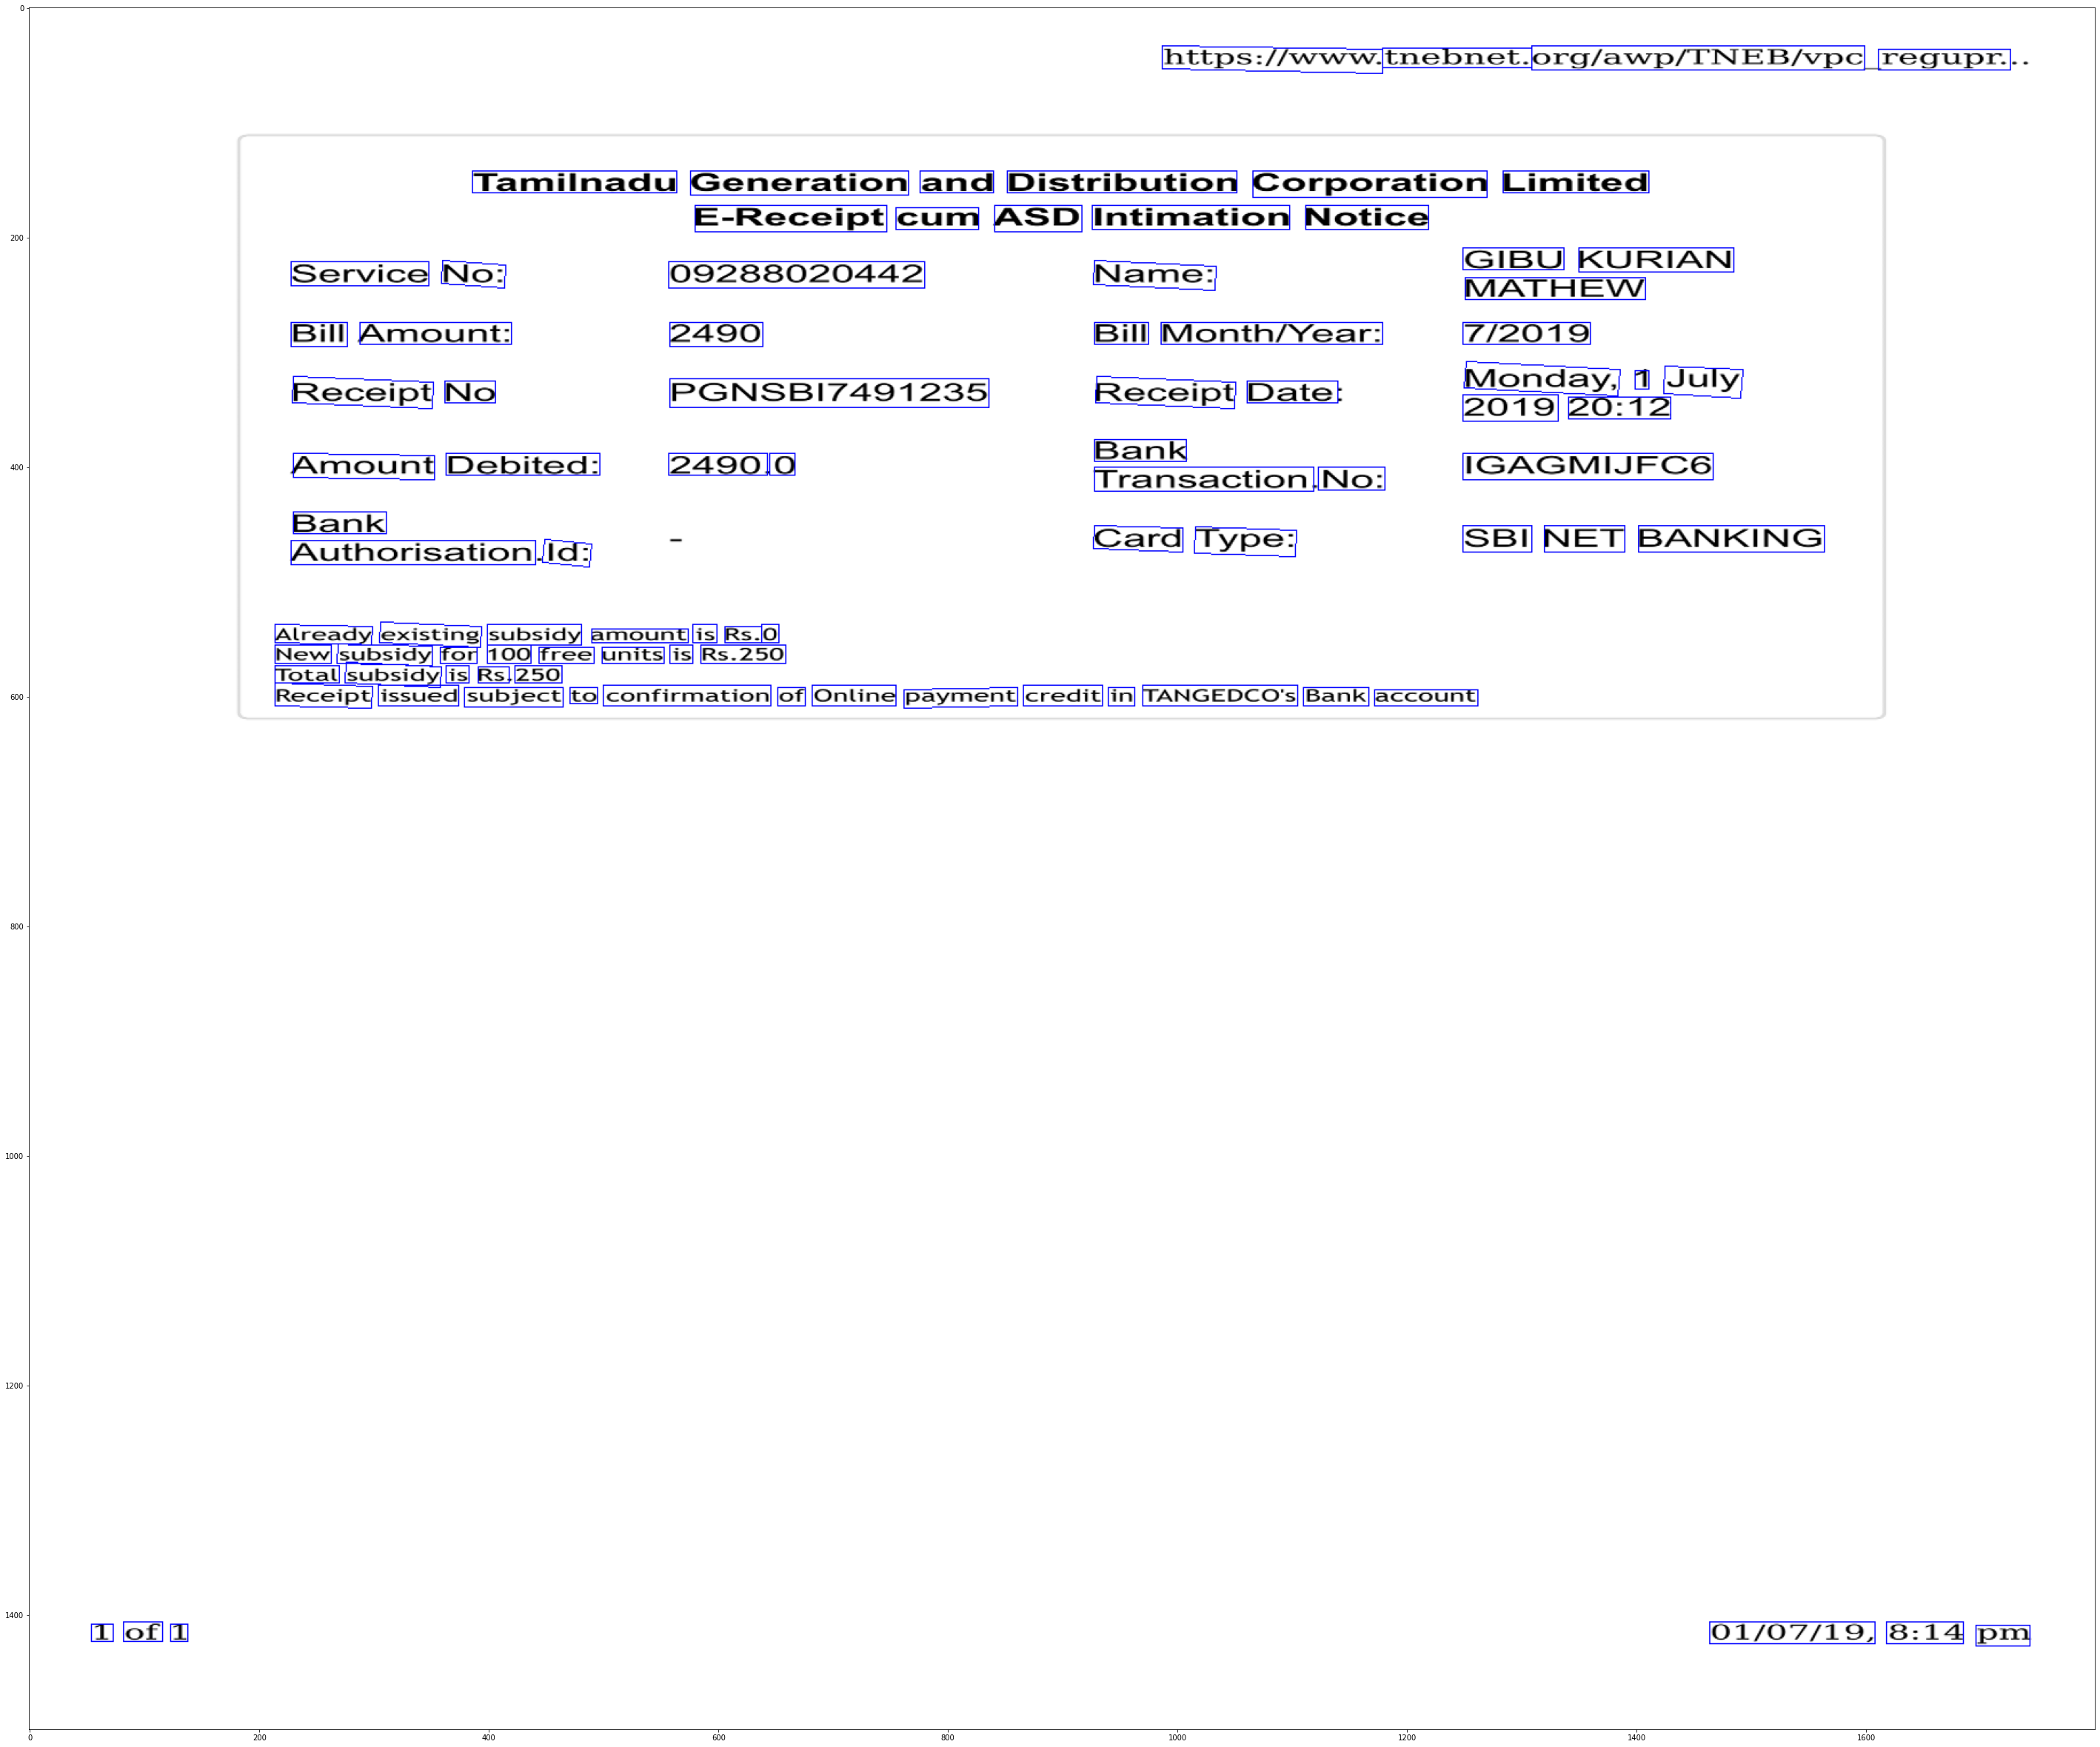

In [68]:
#using the keras_ocr model to recognize the text
for doc in all_docs_list:
    predictions = pipeline.recognize([doc])[0]

#plotting the predictions
    plt.figure(figsize=(50,50))
    drawn = keras_ocr.tools.drawBoxes(image=doc,boxes=predictions, boxes_format='predictions',color=(0,0,255), thickness=1)
    plt.imshow(drawn)

**Refining the bounding box regression**

In [69]:
# writing functions to club the bounding boxes to return the text from a region

def isOnSameLine(boxOne, boxTwo):
    boxOneStartY = boxOne[0,1]
    boxOneEndY = boxOne[2,1]
    boxTwoStartY = boxTwo[0,1]
    boxTwoEndY = boxTwo[2,1]
    if((boxTwoStartY <= boxOneEndY and boxTwoStartY >= boxOneStartY)
    or(boxTwoEndY <= boxOneEndY and boxTwoEndY >= boxOneStartY)
    or(boxTwoEndY >= boxOneEndY and boxTwoStartY <= boxOneStartY)):
        return True
    else:
        return False

def segmentLines(box_group):
    # sort by highest starty value (bottom left corner of box - [startX,startY], [endX,startY], [endX,endY], [startX, endY])
    box_group = box_group[np.argsort(box_group[:, 0, 1])]

    lined_box_group = np.zeros(box_group.shape)
    sorted_box_group = np.zeros(box_group.shape)

    # list of indexes
    temp = []
    i = 0

    # check if there is more than one box in the box_group
    if len(box_group) > 1:
        while i < len(box_group):
            for j in range(i + 1, len(box_group)):
                if(isOnSameLine(box_group[i],box_group[j])):
                    # print(str(i) + " and " + str(j) + " on same line")
                    if i not in temp:
                        temp.append(i)
                    if j not in temp:
                        temp.append(j)
                # else:
                    # print(str(i) + " and " + str(j) + " not on same line")
            # append temp with i if the current box (i) is not on the same line with any other box
            if len(temp) == 0:
                temp.append(i)
            
            # put boxes on same line into lined_box_group array
            lined_box_group = box_group[np.array(temp)]
            # sort boxes by startX value
            lined_box_group = lined_box_group[np.argsort(lined_box_group[:, 0, 0])]
            # copy sorted boxes on same line into sorted_box_group
            sorted_box_group[i:temp[-1]+1] = lined_box_group
            
            # skip to the index of the box that is not on the same line
            i = temp[-1] + 1
            # clear list of indexes
            temp = []
    else:
        # since there is only one box in the boxgroup do nothing but copying the box
        # print("only one box in boxgroup")
        sorted_box_group = box_group
        
    return sorted_box_group

**After defining the functions, the boxes are then merged. Only those who satisfy the conditions for the previous funcitions will be merged.**

In [70]:
#Generate two text boxes a larger one that covers them
def merge_boxes(box1, box2):
    return [min(box1[0], box2[0]), 
         min(box1[1], box2[1]), 
         max(box1[2], box2[2]),
         max(box1[3], box2[3])]

#Computer a Matrix similarity of distances of the text and object
def calc_sim(text, obj):
    # text: ymin, xmin, ymax, xmax
    # obj: ymin, xmin, ymax, xmax
    text_ymin, text_xmin, text_ymax, text_xmax = text
    obj_ymin, obj_xmin, obj_ymax, obj_xmax = obj

    x_dist = min(abs(text_xmin-obj_xmin), abs(text_xmin-obj_xmax), abs(text_xmax-obj_xmin), abs(text_xmax-obj_xmax))
    y_dist = min(abs(text_ymin-obj_ymin), abs(text_ymin-obj_ymax), abs(text_ymax-obj_ymin), abs(text_ymax-obj_ymax))

    dist = x_dist + y_dist
    return dist

#Principal algorithm for merge text 
def merge_algo(texts, texts_boxes):
    for i, (text_1, text_box_1) in enumerate(zip(texts, texts_boxes)):
        for j, (text_2, text_box_2) in enumerate(zip(texts, texts_boxes)):
            if j <= i:
                continue
            # Create a new box if a distances is less than disctance limit defined 
            if calc_sim(text_box_1, text_box_2) < dist_limit:
            # Create a new box  
                new_box = merge_boxes(text_box_1, text_box_2)            
             # Create a new text string 
                new_text = text_1 + ' ' + text_2

                texts[i] = new_text
                #delete previous text 
                del texts[j]
                texts_boxes[i] = new_box
                #delete previous text boxes
                del texts_boxes[j]
                #return a new boxes and new text string that are close
                return True, texts, texts_boxes

    return False, texts, texts_boxes

**Repeating the same keras_ocr model and tweaking it with the functions defined above** 

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5
[['httosawww', 'tnebnet', 'orsawpinebse', 'regupr', 'tamilnadu', 'generation', 'and', 'distribution', 'corporation', 'limited', 'ereceipt', 'cum', 'asd', 'intimation', 'notice', 'service', 'not', 'otzsezna7', 'namer', 'gibu', 'kurian', 'mathev', 'bill', 'amount', '2490', 'bill', 'monthiycan', '712019', 'receipt', 'no', 'pgnsbizan1ss', 'receipt', 'date', 'monday', '1', 'july', '2019', '20112', 'amount', 'debited', '24900', 'bank', 'igagmijece', 'transaction', 'not', 'bank', 'card', 'type', 'sbi', 'net', 'banking', 'authorisatione', 'idf', 'already', 'subsidy', 'existing', '100', 'subsidy', 'amount', 'is', 'rs250', 'rsao', 'new', 'for', 'free', 'units', '15', 'total', 'subsidy', '1s', 'rs', '250', 'tangedcos', 'receipt', 'issued', 'subject', 'to', 'confirmation', 'of', 'online', 'payment', 'credit', 'in', 'bank', 'account', 'l', 'of', 'l', 'o11ozi19', '81', '14', 'pm']]
['httosawww tnebnet orsawpin

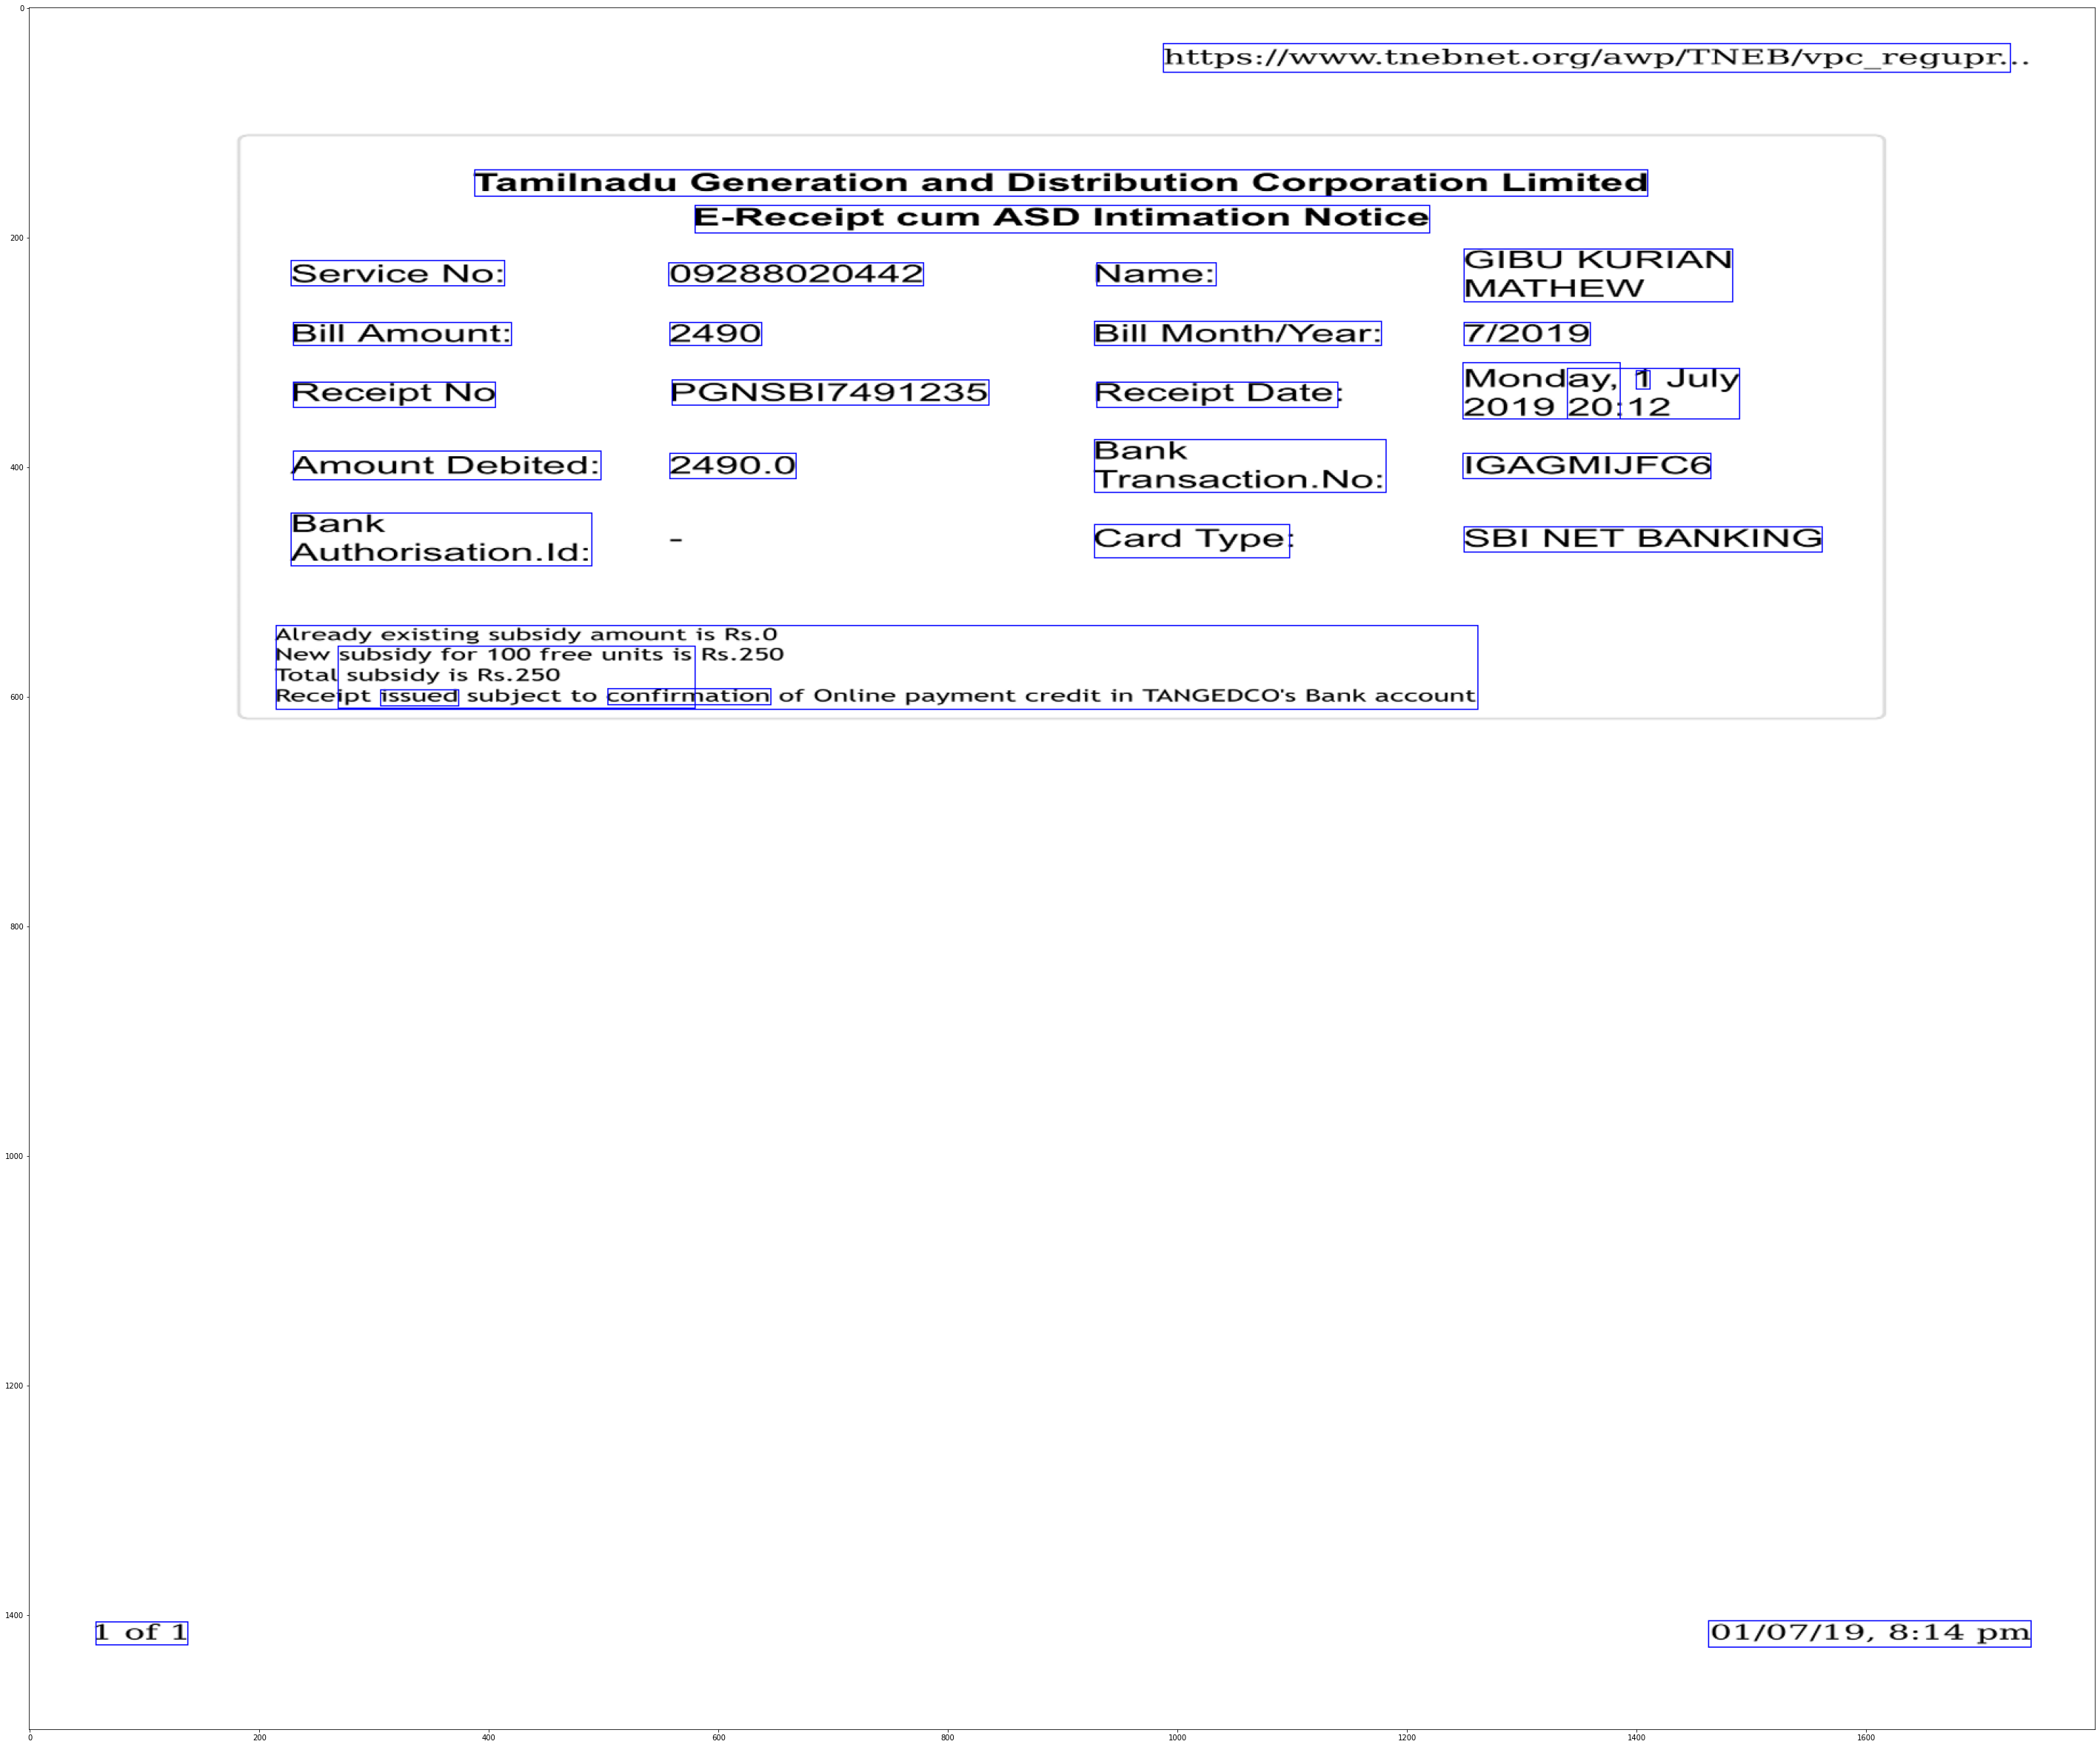

In [71]:
import matplotlib.pyplot as plt

import keras_ocr

# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()

# # Each list of predictions in prediction_groups is a list of
# # (word, box) tuples.
for doc in all_docs_list:
  box_groups = pipeline.detector.detect([doc])
  box_group = box_groups[0]
  
  if len(box_group) > 0:
    # sort bounding boxes into lines
    sorted_box_group = segmentLines(box_group)
    # recognize text
    recognizedtext = pipeline.recognizer.recognize_from_boxes([doc], [sorted_box_group])
    print(recognizedtext)
    text = " ".join(recognizedtext[0])
    # print(text)
  else:
    text = ""
  predictions = [(recognized_text, box) for recognized_text, box in zip(recognizedtext[0], sorted_box_group)]
  
  texts, texts_boxes = [], []
  for text, bbox in predictions:
    texts.append(text)
    x_min, x_max = np.min(bbox[:,0]), np.max(bbox[:,0])
    y_min, y_max = np.min(bbox[:,1]), np.max(bbox[:,1])
    texts_boxes.append([y_min, x_min, y_max, x_max])

  # print(len(texts), len(texts_boxes))

  #Distance definition  between text to be merge
  dist_limit = 15
  #Copy of the text and boxes arrays
  texts_copied = copy.deepcopy(texts)
  texts_boxes_copied = copy.deepcopy(texts_boxes)

  need_to_merge = True
  #Merge full text 
  while need_to_merge:
    need_to_merge, texts_copied, texts_boxes_copied = merge_algo(texts_copied, texts_boxes_copied)
  print(texts_copied)

  merged_bboxes = []
  for merged_box in texts_boxes_copied:
    y_min, x_min, y_max, x_max = merged_box[0], merged_box[1], merged_box[2], merged_box[3]
    merged_bbox = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]])
    merged_bboxes.append(merged_bbox)

  new_predictions = [(recognized_text, box) for recognized_text, box in zip(texts_copied, merged_bboxes)]
  plt.figure(figsize=(50,50))
  drawn = keras_ocr.tools.drawBoxes(
        image=doc, boxes=new_predictions, boxes_format='predictions', color=(0,0,255), thickness=1)
  plt.imshow(drawn)

**using regular expressions to pick the text required**

In [72]:
texts_copied

['httosawww tnebnet orsawpinebse regupr',
 'tamilnadu generation and distribution corporation limited',
 'ereceipt cum asd intimation notice',
 'service not',
 'otzsezna7',
 'namer',
 'gibu kurian mathev',
 'bill amount',
 '2490',
 'bill monthiycan',
 '712019',
 'receipt no',
 'pgnsbizan1ss',
 'receipt date',
 'monday 2019',
 '1',
 'july 20112',
 'amount debited',
 '24900',
 'bank transaction not',
 'igagmijece',
 'bank authorisatione idf',
 'card type',
 'sbi net banking',
 'already existing 100 new free subsidy amount is rs250 rsao total receipt of online payment credit in tangedcos bank account',
 'subsidy for subsidy 1s rs 250 subject to units 15',
 'issued',
 'confirmation',
 'l of l',
 'o11ozi19 81 14 pm']

In [73]:
# using regular expressions to match a sequence or straight out a particular phrase
import re

def re_match(word,text_list):
    for z in text_list:
        match = re.search(word,z)
        if match:
            print('matching word =',match.group(),'\n','matching phrases in the list =',z)

In [74]:
re_match('bill',texts_copied)

matching word = bill 
 matching phrases in the list = bill amount
matching word = bill 
 matching phrases in the list = bill monthiycan


In [77]:
#also the correposding query can also be answered as the boxes are next to each other

def re_find_ans(word,text_list):
    for z in range(len(text_list)):
        match = re.search(word,text_list[z])
        if match:
            print(text_list[z+1])

In [82]:
re_find_ans('receipt no',texts_copied)

pgnsbizan1ss
